In [1]:
import omnitool
from omnitool.literature_values import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We'll use the asteroseismic data from Yu et al. 2018

In [2]:
#Read in Jie Yu
print('Reading in Yu+2018')
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table1.txt'
yu18_1 = pd.read_csv(sfile, sep='|')
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table2.txt'
yu18_2 = pd.read_csv(sfile, sep='|')
yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='outer')
yu18.rename(columns={'KICID':'KIC',
                    'EvoPhase':'stage',
                    'err_x':'numax_err',
                    'err.1_x':'dnu_err',
                    'err_y':'Teff_err',
                     'Fe/H':'[Fe/H]',
                    'err.2_y':'[Fe/H]_err',
                    'err.1_y':'logg_err',
                    'err.3_y':'M_err',
                    'err.4_y':'R_err'},inplace=True) #For consistency

Reading in Yu+2018


First, lets get our asteroseismic values


In [3]:
#Calling the scaling relations class
SC = omnitool.scalings(yu18, yu18.numax, yu18.dnu, yu18.Teff,\
                          _numax_err = yu18.numax_err,\
                          _dnu_err = yu18.dnu_err,\
                          _Teff_err = yu18.Teff_err)

Now lets pull out all the values we can calculate

In [4]:
yu18['aR'] = SC.get_radius()/Rsol
yu18['aR_err'] = SC.get_radius_err()/Rsol
yu18['aM'] = SC.get_mass()/Msol
yu18['aM_err'] = SC.get_mass_err()/Msol
yu18['alogg'] = SC.get_logg()
yu18['alogg_err'] = SC.get_logg_err()
yu18['L'] = SC.get_luminosity()/Lsol
yu18['L_err'] = SC.get_luminosity_err()/Lsol
yu18['Mbol'] = SC.get_bolmag()
yu18['Mbol_err'] = SC.get_bolmag_err()

Calcualting luminosity using basic asteroseismic radius
Calcualting luminosity using basic asteroseismic radius
Calcualting luminosity using basic asteroseismic radius


Lets plot a quick distribution of points on a HR diagram.

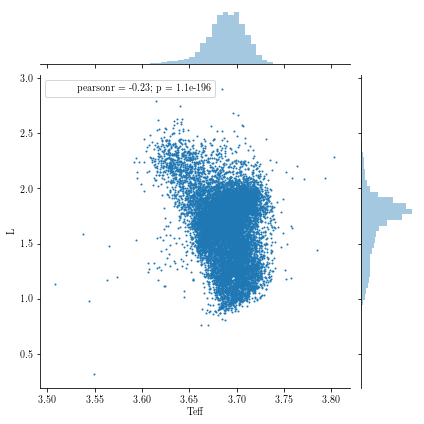

In [5]:
sns.jointplot(np.log10(yu18.Teff), np.log10(yu18.L),s=1)
plt.show()

Now lets say we want to find the K and H band magnitudes of
these stars asteroseismically.
For this, we need an inverse bolometric correction.

In [6]:
#For the bolomteric correction, we need the total metallicity Z
yu18['Z'] = Zsol * 10**yu18['[Fe/H]']

#Now we initialise the class using these values
get_bc = omnitool.bolometric_correction(yu18.Teff.values,\
                                       yu18.logg.values,\
                                       yu18.Z.values)

We now want to calculate the bolometric correction for
these stars in the K, H and J bands

In [7]:
KsBC = get_bc(band='Ks')
HBC = get_bc(band='H')
JBC = get_bc(band='J')

100%|██████████| 16094/16094 [00:08<00:00, 1871.46it/s]


Using this value & the bolometric magnitude we can make the inverse bolometric 
correction

In [8]:
MKs_ast = yu18.Mbol.values - KsBC
MH_ast = yu18.Mbol.values - HBC
MJ_ast = yu18.Mbol.values - JBC

If we want to be extra thorough, we propagate the assumed error
on the bolometric correction

For now this is just guesstimated at 0.02 per Huber et al. 2017, BUT
it should be noted that they use a different method of obtaining the BC

In [9]:
M_ast_err = np.sqrt(yu18.Mbol_err.values**2 + err_bc**2)

Note that this error is the same regardless of passband

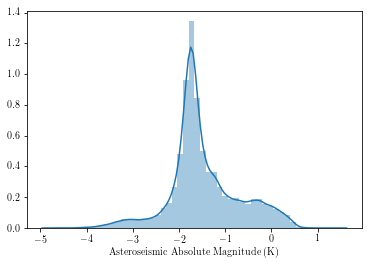

Median in K: -1.645371050647141


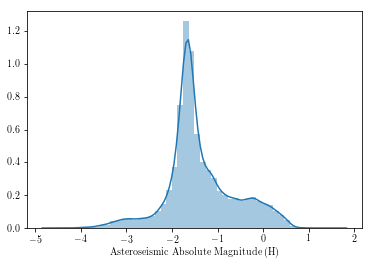

Median in H: -1.5612213320274795


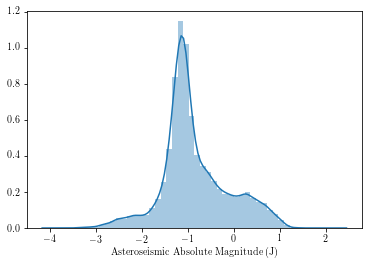

Median in J: -1.0252423764609166


In [10]:
'''Lets plot a distribution of the results...'''
sns.distplot(MKs_ast)
plt.xlabel('Asteroseismic Absolute Magnitude (K)')
plt.show()
print('Median in K: '+str(np.median(MKs_ast)))

sns.distplot(MH_ast)
plt.xlabel('Asteroseismic Absolute Magnitude (H)')
plt.show()
print('Median in H: '+str(np.median(MH_ast)))

sns.distplot(MJ_ast)
plt.xlabel('Asteroseismic Absolute Magnitude (J)')
plt.show()
print('Median in J: '+str(np.median(MJ_ast)))


Lets do a quick plot to illustrate the errors on the data... We'll plot Core He Burning stars only for clarity.

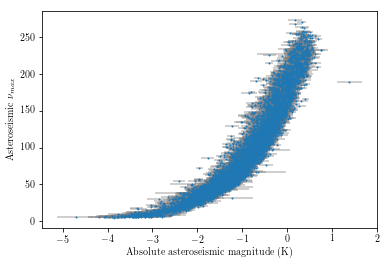

In [11]:
sel = yu18.stage == 1

fig, ax = plt.subplots()
ax.scatter(MKs_ast[sel],yu18.numax[sel],s=1,zorder=1001)
ax.errorbar(MKs_ast[sel],yu18.numax[sel],xerr=M_ast_err[sel], alpha=.5, fmt='none', c='grey',zorder=1000)
ax.set_xlabel('Absolute asteroseismic magnitude (K)')
ax.set_ylabel(r"Asteroseismic $\nu_{\text{max}}$")
plt.show()

Finally, lets compare our results to those obtained in the Yu+18 work to ensure they're the same.

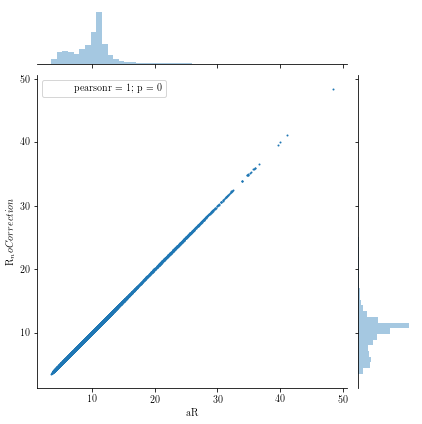

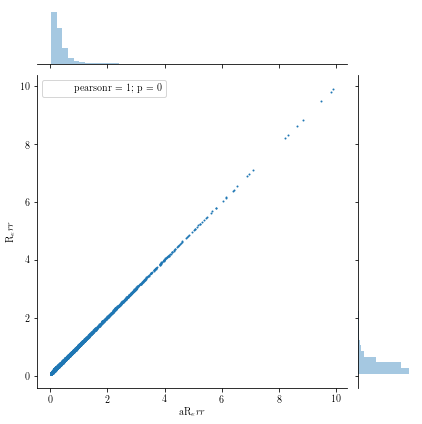

In [13]:
sns.jointplot(yu18.aR, yu18.R_noCorrection, s=1)
sns.jointplot(yu18.aR_err, yu18.R_err,s=1)
plt.show()

Now imagine we want to recalculate luminosity, but using a given corrected radius

In [21]:
#Calling the scaling relations class
SC = omnitool.scalings(yu18, yu18.numax, yu18.dnu, yu18.Teff,\
                          _numax_err = yu18.numax_err,\
                          _dnu_err = yu18.dnu_err,\
                          _Teff_err = yu18.Teff_err)
SC.give_corrections(Rcorr = yu18.R_RGB*Rsol, Rcorr_err = yu18['err.6']*Rsol)
yu18['rgbL'] = SC.get_luminosity()/Lsol
yu18['rgbL_err'] = SC.get_luminosity_err()/Lsol
yu18['rgbMbol'] = SC.get_bolmag()
yu18['rgbMbol_err'] = SC.get_bolmag_err()

Calculating L using a given radius
Calculating L using a given radius
Calculating L using a given radius


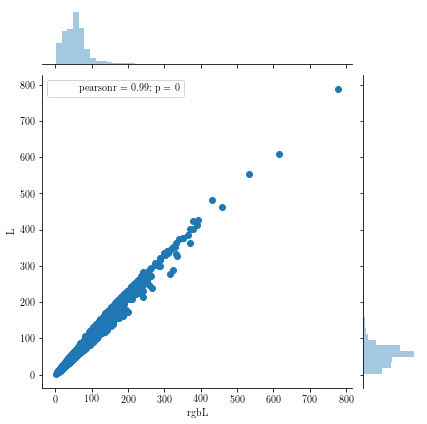

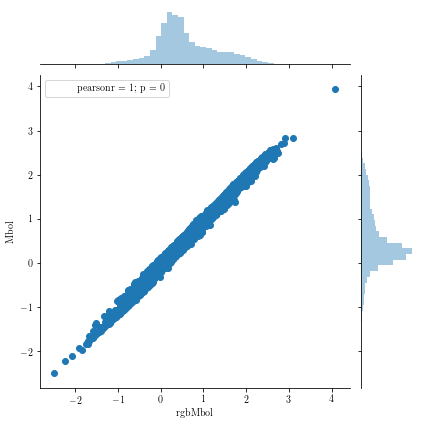

In [24]:
sns.jointplot(yu18.rgbL, yu18.L)
sns.jointplot(yu18.rgbMbol, yu18.Mbol)
plt.show()